# Analysis of Stroke Occurance Based on Health Factors

Author: Amin Eghbalian

Course Project, UC Irvine, Math 10, S23

## Introduction

This study attempts to characterize how different health variables can help predict the occurrence of stroke in patients. The data consists of information on gender, age, hypertension, heart disease, marital status, work type, living residency, average glucose level of blood, BMI, smoking status, and stroke occurrence.
Credit: Stroke Prediction Dataset [https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset]

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pre-cleaned data

Let's import the data and take a look:

In [2]:
df_pre = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df_pre.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
df_pre.shape

(5110, 12)

There is information on 5110 patients on 12 health variables.

We'll take a look at the columns' names and what datatype they consist of.

In [5]:
df_pre.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Prior to any cleaning, there are 5110 rows and 12 columns in the dataset. The types associated with each column seem reasonable constituting integers, floats, and "objects" which are usually strings.

### Data Cleaning

We now look to see if there are any missing data. According to the original publishers, "Unknown" in smoking_status means this patient's information is unavailable. We therefore first set these "Unknown" values to appropriate numpy missing values.

Let's see how many such values exist:

In [6]:
(df_pre["smoking_status"] == "Unknown").sum()

1544

Let's convert all these "Unknown" values to np.nan

In [7]:
indices = df_pre["smoking_status"] == "Unknown"

In [8]:
df_pre.loc[indices, "smoking_status"] = np.nan


In [9]:
df_pre.isna().any(axis=0)

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status        True
stroke               False
dtype: bool

In [10]:
df = df_pre.dropna(axis=0).copy()

In [11]:
df.isna().any(axis=0)

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

The omitting of NA values was successful.

In [12]:
df.shape

(3426, 12)

In [13]:
df.head(3)

id  gender   age  hypertension  heart_disease ever_married work_type  \
0   9046    Male  67.0             0              1          Yes   Private   
2  31112    Male  80.0             0              1          Yes   Private   
3  60182  Female  49.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1

We do not need to use the column named "id" in our analysis so we omit that column.

In [14]:
df = df.drop("id",axis=1).copy()

In [15]:
df.shape

(3426, 11)

We'd like to check if males and females are equally represented in this study, as well as the distribution of age of participants and whether the distribution of BMI is approximately normal or not.

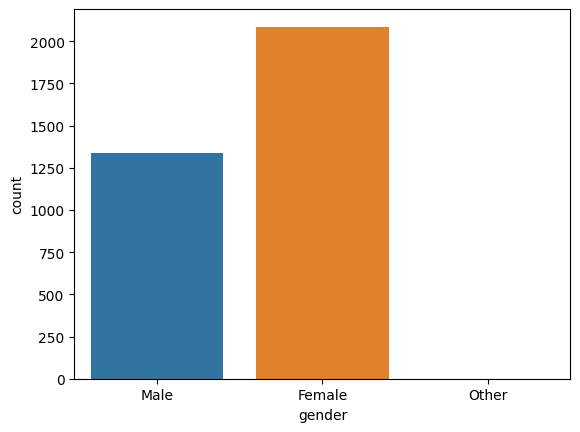

In [16]:
c0 = sns.countplot(data=df, x='gender')

There are more females in our study than males.

In [17]:
df["gender"].value_counts()

Female    2086
Male      1339
Other        1
Name: gender, dtype: int64

There is only one person under category "Other". Any inferences based on such a small sample will not be accurate. We omit this data point from the dataset.

In [18]:
df = df.drop(df[df["gender"] == "Other"].index,axis=0).copy()

In [19]:
df.shape

(3425, 11)

In [20]:
df["gender"].value_counts()

Female    2086
Male      1339
Name: gender, dtype: int64

Let's take a look at the distribution of age and BMI. These two variables are usually normally distributed.

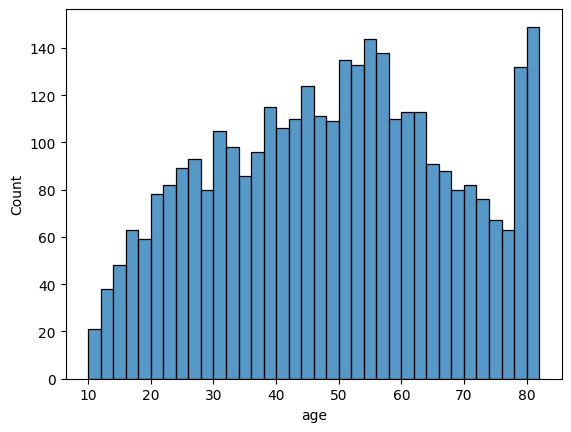

In [21]:
c0 = sns.histplot(data=df, x='age', binwidth=2)


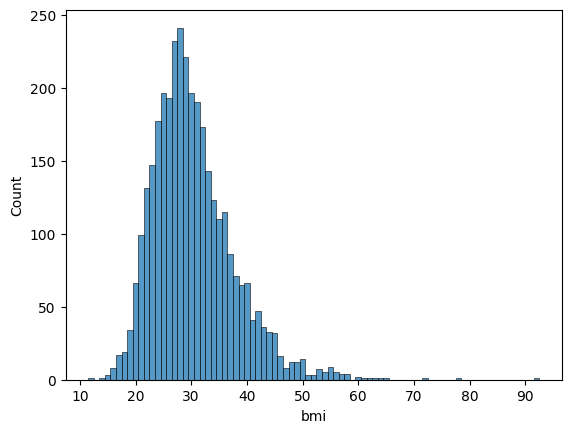

In [22]:
c0 = sns.histplot(data=df, x='bmi', binwidth=1)

The distributions are approximately normal.

## Statistical/ Machine Learning models

### Linear Regression

First, let's see if BMI is related to the average glucose level in the blood. In the real world, the relationship between these two variables is much more complex, but it is reasonable to assume that having a bad diet can cause both higher BMI ratings and higher average glucose levels in the blood.

Here is a scatter plot of data:

In [23]:
c1 = alt.Chart(df).mark_circle().encode(
    x="avg_glucose_level",
    y="bmi",
    color="gender",
    tooltip=["bmi"]
)
c1

alt.Chart(...)

A slight upward trend can be discerned from the graph, and no difference between males and females seems to exist. 

Let's try fitting the linear regression:

In [24]:
reg = LinearRegression()

In [25]:
reg.fit(df[["avg_glucose_level"]],df["bmi"])

LinearRegression()

Here are the coefficient and the intercept estimates:

In [26]:
reg.coef_

array([0.02396019])

In [27]:
reg.intercept_

27.69718204539296

There seems to be a positive correlation between average glucose level and the BMI. Further statistical analysis is required to determine the significance which is outside the scope of current work.

Here is a line graph of the fitted line:

In [28]:
df["bmi_lin_pred"] = reg.predict(df[["avg_glucose_level"]])

In [29]:
c2 = alt.Chart(df).mark_line().encode(
    x="avg_glucose_level",
    y="bmi_lin_pred",
    color=alt.value("red")
)
c1 + c2

alt.LayerChart(...)

### Logistic Regression

Let's try to fit a logistic regression model using age and BMI as covariates and the presence of hypertension as the response variable.

Here is the scatterplot of the data: 

In [30]:
c3 = alt.Chart(df).mark_circle().encode(
    x="age",
    y="bmi",
    color= "hypertension:N"
)
c3

alt.Chart(...)

Let's break the data into train and test datasets to be able to see how good a fit we obtained later on.

In [31]:
cols = ["age", "bmi"]
target = "hypertension"
X_train, X_test, y_train, y_test = train_test_split(df[cols], df[target], test_size=0.2)

Now that we have produced train and test datasets, let's fit the model:

In [32]:
clf = LogisticRegression()

In [33]:
clf.fit(X_train,y_train)

LogisticRegression()

In [34]:
clf.coef_

array([[0.05580016, 0.05825496]])

In [35]:
clf.intercept_

array([-6.94305811])

Both age and BMI covariates seem to have a positive correlation with hypertension. Further statistical analysis is required to determine the significance which is outside the scope of current work.

Let's evaluate the model:

Performance on the training and test sets are:

In [36]:
clf.score(X_train, y_train)

0.8824817518248175

In [37]:
clf.score(X_test, y_test)

0.8802919708029197

The train and test scores are not very different from each other, so overfitting is not an issue. 

We now plot the fitted model [Credit: Chris Davis (UCI)]:

In [38]:
clf.classes_

array([0, 1])

In [39]:
arr = clf.predict_proba(df[cols])

In [40]:
df["pred_proba"] = arr[:,1]

In [41]:
c4 = alt.Chart(df).mark_circle().encode(
    x = "age",
    y = "hypertension",
    color = alt.value("red")
)

In [42]:
c5 = alt.Chart(df).mark_line().encode(
    x = cols[0],
    y = "pred_proba",
    color = alt.value("blue")
)
c4 + c5

alt.LayerChart(...)

The randomness we saw in the scatter plot at the beginning of this section has now become more obvious. In general, it seems that only using age and BMI, will not result in an accurate prediction of hypertension. 

In fact, as demonstrated below, the maximum confidence model achieved when trying to predict the existence of hypertension is only about 70 percent.

In [43]:
clf.predict_proba(df[cols])[:,1].max()

0.6310686866644839

### Polynomial Regression

Looking at the scatter plot of BMI vs age, there seems to be a downward bow shape to the data. Let's try to fit a polynomial regression.

In [44]:
pipe = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)), 
        ("reg", LinearRegression())
    ]
)

In [45]:
cols = ["age"]
target = "bmi"
pipe.fit(df[cols],df[target])

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('reg', LinearRegression())])

In [46]:
pipe["reg"].coef_

array([ 0.48284536, -0.00469686])

In [47]:
pipe["reg"].intercept_

19.586914731326793

Let's graph the polynomial model:

In [48]:
df["bmi_poly_pred"] = pipe.predict(df[cols])

In [49]:
c5 = alt.Chart(df).mark_line(color="red").encode(
    x="age",
    y="bmi_poly_pred"
)
c3+c5

alt.LayerChart(...)

A polynomial model does seem to capture the bend seen in the graph of BMI vs age. Further statistical analysis to determine the goodness of fit is required which outside the scope of current work.

### Decision Tree Classifier

Let us see if the average glucose level of blood and age can adequately describe whether someone has a heart disease by use of a decision tree.

Here is the scatterplot of data:

In [50]:
c6 = alt.Chart(df).mark_circle().encode(
    x = "age",
    y = "avg_glucose_level",
    color = "heart_disease:N"
)
c6

alt.Chart(...)

In [51]:
cols = ["age", "avg_glucose_level"]
target = "heart_disease"
X_train, X_test, y_train, y_test = train_test_split(df[cols], df[target], test_size=0.2)

Decision Tree classifiers are especially notorious for overfitting if there are no constraints imposed.

In [52]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [53]:
clf.score(X_train,y_train)

1.0

In [54]:
clf.score(X_test,y_test)

0.8934306569343066

The model is doing very well on the training dataset but comparably worse on the test dataset. 

Let's impose some constraints:

In [55]:
clf = DecisionTreeClassifier(max_leaf_nodes=50)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=50)

In [56]:
clf.score(X_train,y_train)

0.9547445255474453

In [57]:
clf.score(X_test,y_test)

0.9197080291970803

Now, the model is performing at the same level for both datasets.

We now proceed to sketch the decision boundaries [Credit: Chris Davis (UCI)]:

In [58]:
rng = np.random.default_rng()
arr = rng.random(size=(5000, 2))
df_art = pd.DataFrame(arr, columns=cols)
df_art["age"] *= 70
df_art["age"] += 10
df_art["avg_glucose_level"] *= 225
df_art["avg_glucose_level"] += 50
df_art["pred"] = clf.predict(df_art[cols])

In [59]:
alt.Chart(df_art).mark_circle(size=50).encode(
    x="age",
    y="avg_glucose_level",
    color=alt.Color("pred:N", scale=alt.Scale(scheme="dark2")),
    tooltip=["age", "avg_glucose_level"]
)

alt.Chart(...)

This data does not really allow for perfect visualization of the decision boundaries. However, one can discern some horizontal and vertical boundaries in the top right of the graph which are characteristic of decision trees.

It seems that the model is underpredicting people with heart disease.

In [60]:
clf.classes_

array([0, 1])

In [61]:
(clf.predict_proba(df[cols])[:,1] > 0.5).sum()

77

In [62]:
df["heart_disease"].value_counts()

0    3219
1     206
Name: heart_disease, dtype: int64

There are 206 people with heart disease in the dataset but the model is predicting some fewer than 100 heart disease cases.

This is consistent with the randomness we saw in the scatterplot at the beginning of this section. There is really no trend to data when using age and average glucose level to predict cases of heart disease. 

### Random Forest Classifier

We now turn to the goal of the study; predicting stroke in patients with given parameters.

We will be using age, average glucose level, heart disease, and BMI as covariates and stroke as the response variable.

In [63]:
cols = ["age", "avg_glucose_level", "heart_disease", "bmi"]
target = "stroke"
X_train, X_test, y_train, y_test = train_test_split(df[cols], df[target], test_size=0.2)

In [64]:
rfc = RandomForestClassifier(n_estimators=200, max_leaf_nodes=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=10, n_estimators=200)

Let's see what features are more important in the prediction of stroke in patients:

In [65]:
pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_).sort_values(ascending=False)

age                  0.443998
avg_glucose_level    0.316624
bmi                  0.181479
heart_disease        0.057898
dtype: float64

Expectedly age is an influential factor in predicting stroke in our dataset.

In [66]:
rfc.score(X_train,y_train)

0.9492700729927007

In [67]:
rfc.score(X_test,y_test)

0.9430656934306569

Random Forests are less susceptible to overfitting as demonstrated above.

### Neural Networks

Credit: Christopher J Davis (UCI): https://christopherdavisuci.github.io/UCI-Math-10-W22/Week8/Week8-Videos.html

Let's create and fit a model:

In [68]:
class NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.layers(x)

Let's instantiate an instance of the model:

In [69]:
neuralModel = NeuralModel()

Data must be in the form of torch.tensor to be used with the model:

In [70]:
X = torch.tensor(df[cols].values).to(torch.float)
y = torch.tensor(df[target].values).to(torch.float).reshape(-1,1)

We now fit the model:

In [71]:
neuralModel(X)

tensor([[7.4648e-31],
        [3.7124e-16],
        [1.3427e-22],
        ...,
        [4.2186e-18],
        [1.3907e-10],
        [4.7199e-23]], grad_fn=<SigmoidBackward0>)

Here are the coefficients and the intercept:

In [72]:
for p in neuralModel.parameters():
    print(p)

Parameter containing:
tensor([[-0.1525, -0.3002,  0.4317,  0.2527]], requires_grad=True)
Parameter containing:
tensor([-0.1761], requires_grad=True)


In [73]:
cols

['age', 'avg_glucose_level', 'heart_disease', 'bmi']

Where the top tensor contains estimated coefficients and the bottom tensor contains the estimated intercept.

We now evaluate the the model:

In [74]:
lossFn = nn.BCELoss()

In [75]:
lossFn(neuralModel(X),y) 

tensor(2.3012, grad_fn=<BinaryCrossEntropyBackward0>)

In [76]:
optimizer = torch.optim.SGD(neuralModel.parameters(), lr = 0.005)

Note: Determining learning rate required some trial and error. Generally, A decreasing loss is preferred.

In [77]:
for p in neuralModel.parameters():
    print(p)
    print(p.grad)
    print("")

Parameter containing:
tensor([[-0.1525, -0.3002,  0.4317,  0.2527]], requires_grad=True)
None

Parameter containing:
tensor([-0.1761], requires_grad=True)
None



In [78]:
loss = lossFn(neuralModel(X),y)

In [79]:
optimizer.zero_grad()
loss.backward() # compute gradient

In [80]:
for p in neuralModel.parameters():
    print(p)
    print(p.grad)
    print("")

Parameter containing:
tensor([[-0.1525, -0.3002,  0.4317,  0.2527]], requires_grad=True)
tensor([[-0.9616, -1.1280, -0.0018, -0.4415]])

Parameter containing:
tensor([-0.1761], requires_grad=True)
tensor([-0.0152])



We know have some gradients which we can use to adjust the parameters of the model:

In [81]:
optimizer.step()

In [82]:
for p in neuralModel.parameters():
    print(p)
    print(p.grad)
    print("")

Parameter containing:
tensor([[-0.1477, -0.2946,  0.4317,  0.2549]], requires_grad=True)
tensor([[-0.9616, -1.1280, -0.0018, -0.4415]])

Parameter containing:
tensor([-0.1760], requires_grad=True)
tensor([-0.0152])



We now proceed to train the model:

In [83]:
epochs = 10000

for i in range(epochs):
    loss = lossFn(neuralModel(X),y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%(epochs/10) == 0:
        print(loss)

tensor(2.2401, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2201, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0480, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2178, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7198, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4300, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2975, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2989, grad_fn=<BinaryCrossEntropyBackward0>)


The loss does not converge which means that the model is struggling to find an optimal solution. This is consistent with last section where we used Random Forest classifier.

In [84]:
for p in neuralModel.parameters():
    print(p)
    print(p.grad)
    print("")

Parameter containing:
tensor([[ 0.0368, -0.0387,  0.5444, -0.1573]], requires_grad=True)
tensor([[4.8734, 6.5678, 0.0085, 1.9429]])

Parameter containing:
tensor([-0.4721], requires_grad=True)
tensor([0.0808])



Let's see how well predictions are.

In [85]:
pred_arr = neuralModel(X).detach().numpy()

In [86]:
df["stroke_nn_pred"] = [0 if el < 0.5 else 1 for el in pred_arr]

In [87]:
(df["stroke"] == df["stroke_nn_pred"]).mean()

0.9474452554744526

The model is only correct about 95% of the time which is similar to previous sections.

## Summary

In this work, we looked at multiple health variables and whether/ how they are related to each other. We cleaned the data by removing missing values, and used multiple statistical/ machine learning models to investigate the relationship between variables. The covariate we chose did not produce accurate models. There could other variables that could successfully explain the variation in data, or it could be that some of the present predictors are correlated and therefore are not adding statistical power to the model when they are included.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?

This dataset is obtained from Kaggle.
[https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset]

* List any other references that you found helpful.

UCI Math 10 Notes by Chrisopher J Davis:
[https://christopherdavisuci.github.io/UCI-Math-10-S23/intro.html]

## Submission

Using the Share button at the top right, **enable Comment privileges** for anyone with a link to the project. Then submit that link on Canvas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c37e43b5-107e-4dc2-b556-6bda40e86780' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>